# Applications of CES and comparison with the standard data splitting benchmark

In this notebook we will explore applications of CES to outlier detection and multi-class classification. We further compare the performance of CES to the standard approch -- Data splitting benchmark to demonstrate the power gain of CES. 

See acompanying paper for high level description of two the methods and corresponding algorithms. 

The notebook will break into two parts: 
1. Outlier Detection setting: In this setting we will see CES achieves higher power compared to the data splitting benchmark.
2. Multi-class classification setting: We compute the marginal prediction sets and label-conditional predictions sets with both methods, and we show that both methods achieves the nominal coverge rate while CES produces smaller, and thus more informative prediction sets.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))
    

def evaluate_bh(pvals, labels, alpha):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]
    
    # Apply BH
    purity_test = len(idx_in)/len(pvals)
    reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

    # Evaluate FDP and Power
    rejections = np.sum(reject)
    if rejections > 0:
        fdp = np.sum(reject[idx_in])/reject.shape[0] 
        power = np.sum(reject[idx_out])/len(idx_out)
    else:
        fdp = 0
        power = 0
    return fdp, power

def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [3]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment 1: CES for anomaly detection

### Load MNIST dataset

In [4]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

In [5]:
from datasetMaker import get_class_i, DatasetMaker

x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 8
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


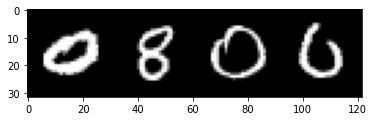

In [6]:
# Plot some sample test data
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), norm=False)

### Benchmark data-splitting vs CES data-splitting

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_data = 300
n_train_bm = 100
n_val_bm = 100
n_cal_bm = 100

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = 200
n_val_ces = 100

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [8]:
# Create data loader objects
# For benchmarks
batch_size = 10
num_workers = 0

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                          num_workers=num_workers)

In [9]:
# Test loader

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

### Define Autoencoder

In [10]:
from method import CES_oneClass
from networks import ConvAutoencoder
import torch.optim as optim

# Define the model parameters

lr = 0.01
n_epoch = 10

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [11]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train benchmark models and compute conformal p-values

In [12]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 10
learning_rate= 0.01


In [13]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_bm.full_train(save_dir = './models/oneClass/benchmarks', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 0.30  took: 0.06s
Epoch 1 of 10, 20% 	 train_loss: 0.29  took: 0.01s
Epoch 1 of 10, 30% 	 train_loss: 0.29  took: 0.01s
Epoch 1 of 10, 40% 	 train_loss: 0.28  took: 0.01s
Epoch 1 of 10, 50% 	 train_loss: 0.26  took: 0.01s
Epoch 1 of 10, 60% 	 train_loss: 0.25  took: 0.01s
Epoch 1 of 10, 70% 	 train_loss: 0.23  took: 0.01s
Epoch 1 of 10, 80% 	 train_loss: 0.21  took: 0.01s
Epoch 1 of 10, 90% 	 train_loss: 0.20  took: 0.01s
Epoch 1 of 10, 100% 	 train_loss: 0.19  took: 0.01s
val_loss = 0.19
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 0.19  took: 0.01s
Epoch 2 of 10, 20% 	 train_loss: 0.18  took: 0.01s
Epoch 2 of 10, 30% 	 train_loss: 0.15  took: 0.01s
Epoch 2 of 10, 40% 	 train_loss: 0.16  took: 0.01s
Epoch 2 of 10, 50% 	 train_loss: 0.15  took: 0.01s
Epoch 2 of 10, 60% 	 train_loss: 0.16  took: 0.01s
Epoch 2 of 10, 70% 	 train_loss: 0.15  took: 0.01s
Epoch 2 of 10, 80% 	 train_loss: 0.14  took: 0.01s
Epoch 2 of 10, 90% 	 train_loss: 0.15 

In [14]:
import time

# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_oc_bm.select_model()
print('selecting models takes:', time.time()-start)

selecting models takes: 0.0010118484497070312


In [16]:
from inference import Conformal_PVals

model_list_bm = CES_oc_bm.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_bm = Conformal_PVals(net_bm, device, cal_loader_bm, [best_model_bm]*len(inputs), random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:35<00:00, 50.03it/s]

Initialization done!
Calibration (one time effort) takes:35.98s.


In [19]:
pvals_bm = C_PVals_bm.compute_pvals(inputs, [best_model_bm]*len(inputs))

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:02<00:00, 800.10it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.514599, average p-value for outliers is 0.610951.


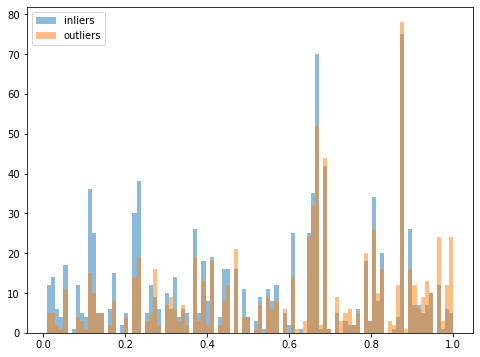

In [20]:
plot_pvals(pvals_bm, labels)

In [21]:
fdp, power = evaluate_bh(pvals_bm, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.000000, power 0.000000.


### Train the CES models

In [22]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)


# Initialize the CES class with model parameters
CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 10
learning_rate= 0.01


In [23]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_ces.full_train(save_dir = './models/oneClass/ces', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 0.17  took: 0.04s
Epoch 1 of 10, 20% 	 train_loss: 0.16  took: 0.02s
Epoch 1 of 10, 30% 	 train_loss: 0.16  took: 0.02s
Epoch 1 of 10, 40% 	 train_loss: 0.15  took: 0.02s
Epoch 1 of 10, 50% 	 train_loss: 0.14  took: 0.02s
Epoch 1 of 10, 60% 	 train_loss: 0.13  took: 0.02s
Epoch 1 of 10, 70% 	 train_loss: 0.11  took: 0.02s
Epoch 1 of 10, 80% 	 train_loss: 0.09  took: 0.02s
Epoch 1 of 10, 90% 	 train_loss: 0.08  took: 0.02s
Epoch 1 of 10, 100% 	 train_loss: 0.06  took: 0.01s
val_loss = 0.05
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 0.06  took: 0.02s
Epoch 2 of 10, 20% 	 train_loss: 0.05  took: 0.02s
Epoch 2 of 10, 30% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 40% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 50% 	 train_loss: 0.04  took: 0.01s
Epoch 2 of 10, 60% 	 train_loss: 0.04  took: 0.02s
Epoch 2 of 10, 70% 	 train_loss: 0.04  took: 0.01s
Epoch 2 of 10, 80% 	 train_loss: 0.03  took: 0.02s
Epoch 2 of 10, 90% 	 train_loss: 0.03 

In [24]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_oc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:01<00:00, 1520.78it/s]

selecting models takes: 11.030048847198486


In [25]:
model_list_ces = CES_oc_ces.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_ces = Conformal_PVals(net_ces, device, val_loader_ces, model_list_ces, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.24it/s]

Initialization done!
Calibration (one time effort) takes:0.22s.


In [26]:
pvals_ces = C_PVals_ces.compute_pvals(inputs, best_model_ces)

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:02<00:00, 778.11it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.523348, average p-value for outliers is 0.094337.


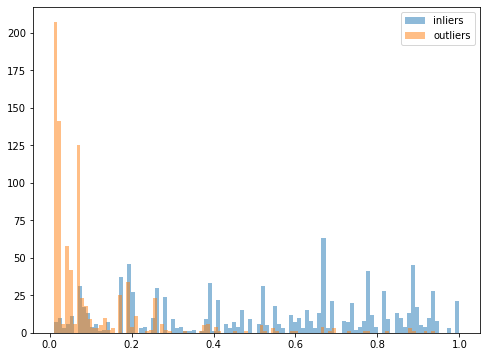

In [27]:
plot_pvals(pvals_ces, labels)

In [28]:
fdp, power = evaluate_bh(pvals_ces, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.047222, power 0.741463.


# Experiment 2: CES for multi-class classification

### Load CIFAR10 dataset

In [29]:
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Benchmark data-splitting vs CES data-splitting

In [30]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_data = 2000
n_val_bm = int(n_data*0.25)
n_cal_bm = n_val_bm
n_train_bm = n_data-n_val_bm-n_cal_bm

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_val_ces = n_val_bm
n_train_ces = n_data-n_val_ces

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [31]:
# Create data loader objects
# For benchmarks
batch_size = 64
num_workers = 4

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=100,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=100,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=100,
                                          num_workers=num_workers)

In [32]:
# Test loader

seed = 99
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

      frog      horse      truck       bird


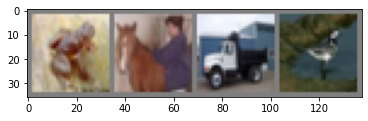

In [33]:
# Plot some sample test data

imshow(torchvision.utils.make_grid(inputs[:4]), norm=True)
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(4)))

### Define CNN

In [57]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [58]:
import torch.optim as optim

# Define the model parameters
lr = 0.001
n_epoch = 10
n_classes = len(classes)

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [59]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train the benchmark model

In [60]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc_bm = CES_multiClass(net_bm, device, train_loader_bm, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [61]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_bm.full_train(save_dir = './models/multiClass/benchmarks', save_every = save_every)

Epoch 1 of 10, 6% 	 train_loss: 2.30 train_acc: 12.50% took: 9.78s
Epoch 1 of 10, 12% 	 train_loss: 2.29 train_acc: 7.81% took: 0.03s
Epoch 1 of 10, 18% 	 train_loss: 2.31 train_acc: 15.62% took: 0.03s
Epoch 1 of 10, 25% 	 train_loss: 2.27 train_acc: 7.81% took: 0.03s
Epoch 1 of 10, 31% 	 train_loss: 2.33 train_acc: 10.94% took: 0.03s
Epoch 1 of 10, 37% 	 train_loss: 2.27 train_acc: 12.50% took: 0.04s
Epoch 1 of 10, 43% 	 train_loss: 2.21 train_acc: 14.06% took: 0.03s
Epoch 1 of 10, 50% 	 train_loss: 2.13 train_acc: 21.88% took: 0.03s
Epoch 1 of 10, 56% 	 train_loss: 2.24 train_acc: 14.06% took: 0.03s
Epoch 1 of 10, 62% 	 train_loss: 2.12 train_acc: 25.00% took: 0.04s
Epoch 1 of 10, 68% 	 train_loss: 2.21 train_acc: 10.94% took: 0.04s
Epoch 1 of 10, 75% 	 train_loss: 2.14 train_acc: 18.75% took: 0.04s
Epoch 1 of 10, 81% 	 train_loss: 2.14 train_acc: 18.75% took: 0.04s
Epoch 1 of 10, 87% 	 train_loss: 2.08 train_acc: 12.50% took: 0.04s
Epoch 1 of 10, 93% 	 train_loss: 2.14 train_acc: 21

Epoch 8 of 10, 68% 	 train_loss: 1.37 train_acc: 51.56% took: 0.02s
Epoch 8 of 10, 75% 	 train_loss: 1.19 train_acc: 65.62% took: 0.02s
Epoch 8 of 10, 81% 	 train_loss: 1.13 train_acc: 60.94% took: 0.02s
Epoch 8 of 10, 87% 	 train_loss: 1.04 train_acc: 68.75% took: 0.02s
Epoch 8 of 10, 93% 	 train_loss: 1.25 train_acc: 59.38% took: 0.02s
Epoch 8 of 10, 100% 	 train_loss: 1.06 train_acc: 65.00% took: 0.02s
val_loss = 1.81 val_acc = 40.00%
Snapshot saved at epoch 8.
Epoch 9 of 10, 6% 	 train_loss: 1.18 train_acc: 56.25% took: 7.88s
Epoch 9 of 10, 12% 	 train_loss: 1.01 train_acc: 71.88% took: 0.02s
Epoch 9 of 10, 18% 	 train_loss: 0.98 train_acc: 70.31% took: 0.02s
Epoch 9 of 10, 25% 	 train_loss: 1.05 train_acc: 60.94% took: 0.03s
Epoch 9 of 10, 31% 	 train_loss: 1.13 train_acc: 64.06% took: 0.03s
Epoch 9 of 10, 37% 	 train_loss: 1.14 train_acc: 60.94% took: 0.03s
Epoch 9 of 10, 43% 	 train_loss: 1.05 train_acc: 70.31% took: 0.02s
Epoch 9 of 10, 50% 	 train_loss: 0.99 train_acc: 67.19% 

In [62]:
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list_bm = CES_mc_bm.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_bm = Conformal_PSet(net_bm, device, cal_loader_bm, n_classes, model_list_bm, \
                           alpha,random_state = seed)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.70s/it]

Initialization done!
Calibration (one time effort) takes:77.00s.


In [63]:
# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_mc_bm.select_model()
print('selecting models takes:', time.time()-start)

selecting models takes: 0.0


In [64]:
# Get the marginal conformal pvalues 
pset_m_bm= C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_bm = C_PSet_bm.pred_set(inputs,[[best_model_bm]*n_classes]*len(inputs), marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.30it/s]

Finished computing marginal prediction sets for 1000 test points.



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.21it/s]

Finished computing label conditional prediction sets for 1000 test points.


In [65]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_bm, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       91.600%
Average size:            5.902
Average size | coverage: 5.927
Conditional coverage for label plane:       88.350%
Average size:            5.971
Average size | coverage: 5.989
Conditional coverage for label car:       95.506%
Average size:            5.404
Average size | coverage: 5.376
Conditional coverage for label bird:       89.000%
Average size:            6.300
Average size | coverage: 6.449
Conditional coverage for label cat:       94.175%
Average size:            5.961
Average size | coverage: 5.969
Conditional coverage for label deer:       86.667%
Average size:            6.222
Average size | coverage: 6.231
Conditional coverage for label dog:       84.884%
Average size:            5.779
Average size | coverage: 5.863
Conditional coverage for label frog:       99.107%
Average size:            5.705
Average size | coverage: 5.694
Conditional coverage for label horse:       91.176%
Average size:            6.50

In [66]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_bm, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       90.900%
Average size:            6.110
Average size | coverage: 6.149
Conditional coverage for label plane:       88.350%
Average size:            6.291
Average size | coverage: 6.308
Conditional coverage for label car:       95.506%
Average size:            5.281
Average size | coverage: 5.247
Conditional coverage for label bird:       89.000%
Average size:            6.740
Average size | coverage: 6.910
Conditional coverage for label cat:       97.087%
Average size:            6.146
Average size | coverage: 6.160
Conditional coverage for label deer:       94.444%
Average size:            6.522
Average size | coverage: 6.541
Conditional coverage for label dog:       83.721%
Average size:            6.058
Average size | coverage: 6.069
Conditional coverage for label frog:       97.321%
Average size:            6.000
Average size | coverage: 6.000
Conditional coverage for label horse:       94.118%
Average size:       

### Train the CES model

In [67]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)

# Initialize the CES class with model parameters
CES_mc_ces = CES_multiClass(net_ces, device, train_loader_ces, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [68]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [69]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_ces.full_train(save_dir = './models/multiClass/ces', save_every = save_every)

Epoch 1 of 10, 8% 	 train_loss: 2.30 train_acc: 14.84% took: 6.49s
Epoch 1 of 10, 16% 	 train_loss: 2.22 train_acc: 21.09% took: 0.04s
Epoch 1 of 10, 25% 	 train_loss: 2.24 train_acc: 13.28% took: 0.04s
Epoch 1 of 10, 33% 	 train_loss: 2.20 train_acc: 19.53% took: 0.05s
Epoch 1 of 10, 41% 	 train_loss: 2.05 train_acc: 29.69% took: 0.04s
Epoch 1 of 10, 50% 	 train_loss: 2.18 train_acc: 21.09% took: 0.04s
Epoch 1 of 10, 58% 	 train_loss: 2.05 train_acc: 28.91% took: 0.04s
Epoch 1 of 10, 66% 	 train_loss: 2.06 train_acc: 28.91% took: 0.04s
Epoch 1 of 10, 75% 	 train_loss: 2.11 train_acc: 23.44% took: 0.03s
Epoch 1 of 10, 83% 	 train_loss: 1.99 train_acc: 22.66% took: 0.03s
Epoch 1 of 10, 91% 	 train_loss: 2.05 train_acc: 29.69% took: 0.04s
Epoch 1 of 10, 100% 	 train_loss: 2.00 train_acc: 24.00% took: 0.03s
val_loss = 2.04 val_acc = 27.40%
Snapshot saved at epoch 1.
Epoch 2 of 10, 8% 	 train_loss: 1.87 train_acc: 31.25% took: 6.73s
Epoch 2 of 10, 16% 	 train_loss: 1.87 train_acc: 30.47% t

Epoch 10 of 10, 75% 	 train_loss: 0.88 train_acc: 75.00% took: 0.08s
Epoch 10 of 10, 83% 	 train_loss: 0.89 train_acc: 67.97% took: 0.07s
Epoch 10 of 10, 91% 	 train_loss: 0.82 train_acc: 78.12% took: 0.07s
Epoch 10 of 10, 100% 	 train_loss: 0.73 train_acc: 81.03% took: 0.06s
val_loss = 1.86 val_acc = 37.80%
Snapshot saved at epoch 10.
Training done! A list of 10 models saved.


In [70]:
import time
alpha = 0.1
model_list_ces = CES_mc_ces.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_ces = Conformal_PSet(net_ces, device, val_loader_ces, n_classes, model_list_ces, \
                           alpha,random_state = seed)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.65s/it]

Initialization done!
Calibration (one time effort) takes:76.46s.


In [71]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_mc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.05it/s]

Loading model 1 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.75it/s]

Loading model 2 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.48it/s]

Loading model 3 of 10...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.35it/s]

Loading model 4 of 10...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.44it/s]

Loading model 5 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.67it/s]

Loading model 6 of 10...



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.24it/s]


Loading model 7 of 10...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.45it/s]

Loading model 8 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.75it/s]

Loading model 9 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.97it/s]

selecting models takes: 98.66001629829407


In [72]:
# Get the marginal conformal pvalues 
pset_m_ces= C_PSet_ces.pred_set(inputs, best_model_ces, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_ces = C_PSet_ces.pred_set(inputs, best_model_ces, marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.29it/s]

Finished computing marginal prediction sets for 1000 test points.



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.40it/s]

Finished computing label conditional prediction sets for 1000 test points.


In [73]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_ces, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       90.600%
Average size:            5.150
Average size | coverage: 5.164
Conditional coverage for label plane:       79.612%
Average size:            4.903
Average size | coverage: 4.805
Conditional coverage for label car:       93.258%
Average size:            4.202
Average size | coverage: 4.205
Conditional coverage for label bird:       97.000%
Average size:            5.680
Average size | coverage: 5.691
Conditional coverage for label cat:       91.262%
Average size:            5.709
Average size | coverage: 5.787
Conditional coverage for label deer:       82.222%
Average size:            5.544
Average size | coverage: 5.689
Conditional coverage for label dog:       94.186%
Average size:            5.535
Average size | coverage: 5.531
Conditional coverage for label frog:       94.643%
Average size:            5.964
Average size | coverage: 5.972
Conditional coverage for label horse:       94.118%
Average size:            5.15

In [74]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_ces, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       92.100%
Average size:            5.688
Average size | coverage: 5.705
Conditional coverage for label plane:       93.204%
Average size:            5.243
Average size | coverage: 5.219
Conditional coverage for label car:       97.753%
Average size:            4.854
Average size | coverage: 4.816
Conditional coverage for label bird:       92.000%
Average size:            6.310
Average size | coverage: 6.391
Conditional coverage for label cat:       90.291%
Average size:            6.272
Average size | coverage: 6.409
Conditional coverage for label deer:       87.778%
Average size:            6.022
Average size | coverage: 6.177
Conditional coverage for label dog:       94.186%
Average size:            6.140
Average size | coverage: 6.185
Conditional coverage for label frog:       91.071%
Average size:            6.464
Average size | coverage: 6.480
Conditional coverage for label horse:       95.098%
Average size:       